# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import ndimage
import import_ipynb
import pandas as pd
import os

In [2]:
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from SpatialTemporal_Correlation_and_Convolution import STconvolve
from StimulusnResponse import SSG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import SG
from Spike_Generation import NL
%matplotlib inline

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["mathtext.fontset"] = "cm"

In [4]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [5]:
def ParaTrans(ASparadict, mag):     # because of overfitting, I assume alpha = mag*beta
    for k in ASparadict.keys():
        globals()[k] = ASparadict[k]
    global beta, alpha, g, l, Amp 
    
    beta = epsilon*2/(1+mag)
    alpha = epsilon*2*mag/(1+mag)
    g = omegastar**2 + (alpha-beta)**2 /4
    l = ((2*omegastar*np.tan(deltastar)*(-beta+gamma)+(alpha-beta)*(beta-gamma)+2*g)/
                (g*(-alpha-beta+2*gamma-2*omegastar*np.tan(deltastar))))
    Amp = Dmp*(g+alpha*beta-alpha*gamma-beta*gamma+gamma**2)/(-beta+gamma+g*l)
    DiffParadict = {'alpha':[], 'beta':[], 'gamma':[], 'g':[], 'l':[], 'tau_y':[], 'Amp':[], 'error':[]}
    for k in DiffParadict.keys():
        DiffParadict[k] = globals()[k]
    return DiffParadict

In [6]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

def NGD2L1D_STK(Xax, Tax, sigma_dict, para_dict, ds = (1,60)):
    dx = np.mean(np.diff(Xax)) / ds[0]
    klen = min(max(sigma_dict.values())*8, Xax[-1])
    xx = np.arange(0,klen+dx,dx)
    xx = np.append(-np.flip(xx),xx[1:])
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
    
    dt = np.mean(np.diff(Tax)) / ds[1]
    Tax = np.arange(0, Tax[-1]+dt, dt)
    x = Tax/para_dict['tau_y'] /para_dict['tau_y']*np.exp(-Tax/para_dict['tau_y'])*dt
    stimulus = np.zeros([len(x), int(2*(int(len(Xax)-1)/2)*ds[0]+1)])
    stimulus[:,int((int(len(Xax)-1)/2)*ds[0])] = x

    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    for i in np.arange(len(x)-1):
        s = stimulus[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(yts[i,:],KC,'same')*dx
        dyj =(-para_dict['alpha']*yts[i,:] + rs - zts[i,:])*dt
        rzs = np.convolve(zts[i,:],KC,'same')*dx
        dzj =(-para_dict['beta'] *zts[i,:] + para_dict['g']*ry2z)*dt
        ry2w = np.convolve(yts[i,:],KB,'same')*dx
        rz2w = np.convolve(zts[i,:],KH,'same')*dx
        dwj =(-para_dict['gamma']*wts[i,:] + ry2w - para_dict['l']*rz2w)*dt
        yts[i+1,:] = (yts[i,:]+dyj)
        zts[i+1,:] = (zts[i,:]+dzj)
        wts[i+1,:] = (wts[i,:]+dwj)
    yts = yts[::ds[1] ,::ds[0]]/dx/dt
    zts = zts[::ds[1] ,::ds[0]]/dx/dt
    wts = wts[::ds[1] ,::ds[0]]/dx/dt

        
    return para_dict['Amp']*wts, zts, yts

# Setting parameters from Exp. data

In [7]:
exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513'
direction = 'UD'
cn = 9

## Temporal 

In [8]:
NGD2L1DASpara = np.load(exp_folder + '\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)
for k in NGD2L1DASpara.files:
    vars()[k] = NGD2L1DASpara[k][()]

pd.DataFrame(para_dict).loc[cn-1]

epsilon       7.163241
gamma        34.901452
omegastar    20.631698
deltastar    -0.450280
tau_y         0.028650
Dmp           3.389743
error         1.308050
Name: 8, dtype: float64

In [9]:
dt = 0.01 #large dt will cause  overflow
Tstep = int(1./dt)
TKtaxis = np.arange(Tstep)*dt

FBFF_para_dict  = pd.DataFrame(ParaTrans(para_dict, 0.1)).loc[cn-1]
FBFF_para_dict

alpha      1.302408
beta      13.024075
gamma     34.901452
g        460.016331
l          0.021331
tau_y      0.028650
Amp      127.832600
error      1.308050
Name: 8, dtype: float64

## Spatial 

In [10]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)
micro_per_pixel = BS['micro_per_pixel']

RFprop  = loadmat(exp_folder+'\\Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat', squeeze_me =True)

hLA = RFprop['RF_properties'][cn-1]['X_Width'] #semi-major-axis
hSA = RFprop['RF_properties'][cn-1]['Y_Width'] #semi-minor-axis
theta = RFprop['RF_properties'][cn-1]['Angle'] #Angel between major-axis and x-axis
YC = RFprop['RF_properties'][cn-1]['Y_Coor']-BS['meaCenter_y'] #ellipse y-center to Motion center
XC = RFprop['RF_properties'][cn-1]['X_Coor']-BS['meaCenter_x'] #ellipse x-center to Motion center

In [11]:
if direction == 'RL':  #'LR' actually
    DisFC = XC *micro_per_pixel *0.001 # distance from center #mm
    RaMD =  hLA*hSA/np.sqrt( (hLA*np.sin(theta))**2 + (hSA*np.cos(theta))**2 ) *0.001 #radius along motion direction #mm
elif direction == 'UL_DR':
    DisFC = (XC+YC)/np.sqrt(2)
    RaMD =  hLA*hSA/np.sqrt( (hLA*np.sin(np.pi/4+theta))**2 + (hSA*np.cos(np.pi/4+theta))**2 ) *0.001
elif direction == 'UD':
    DisFC = YC *micro_per_pixel *0.001 
    RaMD =  hLA*hSA/np.sqrt( (hLA*np.sin(np.pi/2+theta))**2 + (hSA*np.cos(np.pi/2+theta))**2 ) *0.001
elif direction == 'UR_DL':
    DisFC = (-XC+YC)/np.sqrt(2)
    RaMD =  hLA*hSA/np.sqrt( (hLA*np.sin(np.pi*3/4+theta))**2 + (hSA*np.cos(np.pi*3/4+theta))**2 ) *0.001

In [12]:
RaMD/1.5

0.20426678569344126

In [13]:
FBFF_sigma_dict = dict()
FBFF_sigma_dict['B'] = RaMD *1.1/1.5 #mm from exp data (RF radius = 1.5*sigma)
FBFF_sigma_dict['H'] = 3*FBFF_sigma_dict['B'] # 
FBFF_sigma_dict['C'] = 0.05*FBFF_sigma_dict['B'] # has to be small enough

dx = 0.005 #(mm) OLED pixel2micro = 7.6
hXstep =  int(2 /dx) #Half length of xais, (mm)
# hXstep =  int(1.015 /dx) #range of Checkboard, 1.5*sqrt(2)/2
SKxaxis = np.arange(-hXstep,hXstep+1)*dx

In [14]:
FBFF_sigma_dict

{'B': 0.2246934642627854, 'H': 0.6740803927883562, 'C': 0.01123467321313927}

# STK

In [15]:
Delta_output_w, zts, Delta_output_y = NGD2L1D_STK(SKxaxis, TKtaxis, FBFF_sigma_dict, FBFF_para_dict)

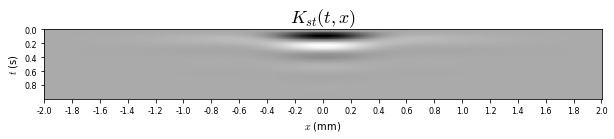

In [16]:
plt.rcParams["font.size"] = 10
plt.rcParams['xtick.labelsize'] =  8
plt.rcParams['ytick.labelsize'] =  8

plt.imshow(-Delta_output_w, cmap = 'gray')
plt.yticks(np.arange(0,(len(TKtaxis)),20), np.round(TKtaxis[::20],1))
plt.ylabel(r'$t$ (s)')
plt.xticks(np.arange(0,(len(SKxaxis)),40), np.round(SKxaxis[::40],2))
plt.xlabel(r'$x$ (mm)')
plt.title(r'$K_{st}(t, x)$', fontsize = 18)
plt.gcf().set_size_inches(10, 5)


In [17]:
np.arange(0,len(TKtaxis),20)

array([ 0, 20, 40, 60, 80])

In [18]:
delSTK = Delta_output_w
# delSTK2 = Delta_output_w2/dt/dx

In [19]:
iSK = np.sum(delSTK, axis = 0)*dt
iTK = np.sum(delSTK, axis = 1)*dx
SeSTK = iTK[:, np.newaxis]*iSK[np.newaxis, :]
SeSTK = SeSTK/np.max(SeSTK)*np.max(delSTK)

# Berry Seperate

[]

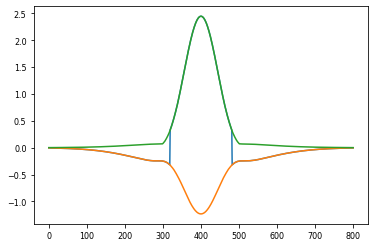

In [20]:
# https://click.endnote.com/viewer?doi=10.1038%2F386069a0&token=WzUyMjY0OCwiMTAuMTAzOC8zODYwNjlhMCJd.MeBUHfQmaH58cpTPXUs8cONUfkM
BerryTK = iTK.copy()
BerrySK = [delSTK[np.argmax( np.abs(delSTK[:,i]) ), i] for i in range(delSTK.shape[1]) ]
minBerrySK = [delSTK[np.argmin( delSTK[:,i]) , i] for i in range(delSTK.shape[1]) ]
maxBerrySK = [delSTK[np.argmax( delSTK[:,i]) , i] for i in range(delSTK.shape[1]) ]
plt.plot(BerrySK)
plt.plot(minBerrySK)
plt.plot(maxBerrySK)
plt.plot( )

# SVD

In [21]:
from numpy import linalg as la
U,sigma,VT=la.svd(delSTK)

In [22]:
print((sigma/sum(sigma))[:5])
for i in range(2):
    if U[2,i] <0:
        VT[i,:] = -VT[i,:]
        U[:,i] = -U[:,i]
        

SVDSTK = U[:,0][:, np.newaxis]*VT[0,:][np.newaxis, :]*sigma[0]

[8.49907225e-01 1.49701790e-01 3.59998834e-04 2.06218691e-05
 5.93997354e-06]


In [23]:
# fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
# ax2.plot(U[:,0])
# ax2.set_title('SVD1 Temporal Kernel')
# ax3.plot(VT[0,:])
# ax3.set_title('SVD1 Spatial Kernel')
# ax4.plot(U[:,1])
# ax4.set_title('SVD2 Temporal Kernel')
# ax5.plot(VT[1,:])
# ax5.set_title('SVD2 Spatial Kernel')
# fig.set_size_inches(10, 5)

[0.06018487 0.20558405]
{'B': 0.2246934642627854, 'H': 0.6740803927883562, 'C': 0.01123467321313927}


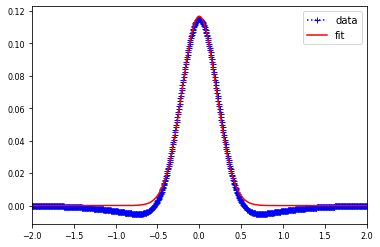

In [24]:
from scipy.optimize import curve_fit
SK = VT[0,:]

def Gaussian(x, a1, sigma1):
    return a1*Gaussian_filter_1d(x,sigma1)

popt,pcov = curve_fit(Gaussian, SKxaxis, SK, p0=[max(SK), 23], bounds = (0, np.inf))
print(popt)
print(FBFF_sigma_dict)
plt.plot(SKxaxis, SK, 'b+:', label='data')
plt.plot(SKxaxis,  Gaussian(SKxaxis, *popt), 'r-', label='fit')
plt.xlim([-2, 2])
plt.legend()

RF = Gaussian(SKxaxis, *popt)

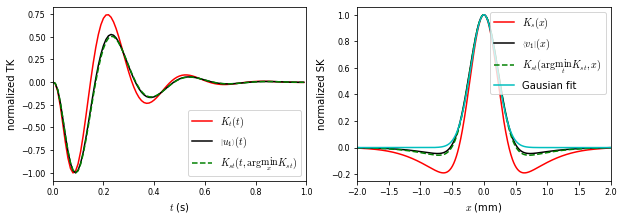

In [26]:
fig, ax = plt.subplots(1,2)
ax[1].plot(SKxaxis, iSK/np.max(iSK), 'r',label=r'$K_s(x)$')
ax[1].plot(SKxaxis, VT[0,:]/np.max(VT[0,:]), 'k',label=r'$\left\langle {v_1} \right|(x)$')
ax[1].plot(SKxaxis, delSTK[np.where(delSTK == np.max(delSTK))[0][0], :]/np.max(delSTK), 'g--',label=r'$K_{st}(\arg\min_{t} K_{st}, x)$')
ax[1].plot(SKxaxis, RF/np.max(RF), 'c',label='Gausian fit')
ax[1].legend(loc='best')
ax[1].set_ylabel('normalized SK')
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_xlim([-2,2])

ax[0].plot(TKtaxis, -iTK/np.max(iTK), 'r',label=r'$K_t(t)$')
ax[0].plot(TKtaxis, -U[:,0]/np.max(U[:,0]), 'k', label=r'$\left| u_1 \right\rangle(t)$')
ax[0].plot(TKtaxis, -delSTK[:, np.where(delSTK == np.max(delSTK))[1][0]]/np.max(delSTK), 'g--',label=r'$K_{st}(t, \arg\min_{x} K_{st})$')
ax[0].set_xlabel(r'$t$ (s)')
ax[0].set_ylabel('normalized TK')
ax[0].set_xlim([0,1])
# ax[0].plot(TKtaxis, U[:,1]/np.max(U[:,1]) *sigma[1]/sigma[0], label='u2')

ax[0].legend(loc='best')
fig.set_size_inches(10,3.2)

# LPOU 

In [ ]:
def STconvolve(x,k,dx,dt):
    output = np.zeros([x.shape[0],k.shape[1]])
    for i in range(x.shape[0]):
        for ii in np.arange(max(i-k.shape[0]+1, 0), i+1):
            output[i,:] += np.convolve(x[ii,:],k[i-ii, :],'same')*dx*dt
    return output
def SquareWave(hw): #hw is dimensionless
    xaxis = np.arange(-hw-1, hw+2)
    SW = np.ones_like(xaxis)
    SW[[0,-1]] = 0
    return SW
def GaussianWave(s):#sigma is dimensionless
    xaxis = np.arange(-5*s, 5*s+1)
    return (np.exp(-(xaxis/s)**2/2))

In [27]:
DR = BS['mea_size']*micro_per_pixel *0.001 #mm
dDR = int(DR/dx+0.5)

Tto = 60
LPOUtaxis = np.arange(0,Tto,dt)
LPOU_list = SSG([0.5,1,2,4], dt, Tto, tau = 1, D = 1)[:-1]
rsLPOU_list = [((LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*(dDR-1E-6) - dDR/2 ).astype(int) for LPOU in LPOU_list]

In [ ]:
LPOU_bar_list = []
for rsLPOU in rsLPOU_list:
    LPOU_bar = np.zeros([len(rsLPOU),len(SKxaxis)])
    for i in range(len(rsLPOU)):
        LPOU_bar[i, rsLPOU[i]+hXstep+1] = 1
    LPOU_bar_list.append( LPOU_bar.copy() )

In [ ]:
STK_r_list = [ STconvolve(LPOU_bar,delSTK,dx,dt)                                                      for LPOU_bar in LPOU_bar_list]
SVD_r_list = [ STconvolve(LPOU_bar,SVDSTK,dx,dt)                                                      for LPOU_bar in LPOU_bar_list]
Inten_list = [ np.array([np.convolve(LPOU_bar[i, :], RF, 'same') for i in range(LPOU_bar.shape[0])])  for LPOU_bar in LPOU_bar_list]

In [ ]:
BW = (2*BS['bar_wid']+1)*micro_per_pixel *0.001 #mm
hw = int(BW/dx/2)

Inten_list = [np.array([np.convolve(Inten[i, :], SquareWave(hw), 'same') for i in range(LPOU_bar.shape[0])])  for Inten in Inten_list]
STK_r_list = [np.array([np.convolve(STK_r[i, :], SquareWave(hw), 'same') for i in range(LPOU_bar.shape[0])])  for STK_r in STK_r_list]
SVD_r_list = [np.array([np.convolve(SVD_r[i, :], SquareWave(hw), 'same') for i in range(LPOU_bar.shape[0])])  for SVD_r in SVD_r_list]

In [ ]:
CellIndex = int(np.interp(DisFC, SKxaxis, np.arange(len(SKxaxis)))+0.5)
I1_list = [Inten[:, CellIndex] for Inten in Inten_list]
r1_list = [STK_r[:, CellIndex] for STK_r in STK_r_list]
SVDr1_list = [SVD_r[:, CellIndex] for SVD_r in SVD_r_list]
# plt.plot(LPOUtaxis, r1/max(r1))
# plt.plot(LPOUtaxis, I1/max(I1))
# plt.plot(LPOUtaxis, LPOU/5)

## STA

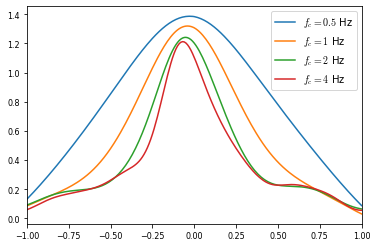

In [ ]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt
STKXcorr = []
for i in range(len(Inten_list)):
    x = np.array(I1_list[i])
    x = (x-np.mean(x))/np.std(x)

    r = r1_list[i]
    r = NL(r, np.mean(r))
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    plt.plot(timeaxis,Xcorr)
    plt.xlim(window)
    plt.legend( (r'$f_c=0.5$ Hz', r'$f_c=1$ Hz', r'$f_c=2$ Hz', r'$f_c=4$ Hz'))
    
    STKXcorr.append( Xcorr.copy() )

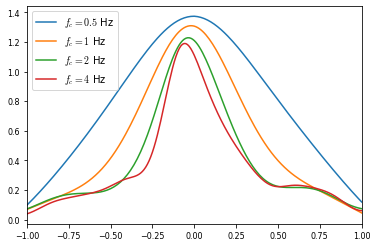

In [ ]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt
SVDSTKXcorr = []
for i in range(len(Inten_list)):
    x = np.array(I1_list[i])
    x = (x-np.mean(x))/np.std(x)

    r = SVDr1_list[i]
    r = NL(r, np.mean(r))
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    plt.plot(timeaxis,Xcorr)
    plt.xlim(window)
    plt.legend( (r'$f_c=0.5$ Hz', r'$f_c=1$ Hz', r'$f_c=2$ Hz', r'$f_c=4$ Hz'))
    
    SVDSTKXcorr.append( Xcorr.copy() )

## MI

In [ ]:
tv_list = [ ndimage.gaussian_filter1d(x, order=1, sigma=1)/dt  for LPOU_list in LPOU_list]
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0]  for LPOU_list in LPOU_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

In [ ]:
STKrstate_list = [ SG(r, dt, 0, 10, 10) for r in r1_list]

window = [-1,1] # second
STKInformation_list = [0]*len(LPOU_list)
for i in range(len(LPOU_list)):
    timeshift, STKInformation_list[i] = PIfunc(STKrstate_list[i], xstate_list[i], tvstate_list[i], dt, window)

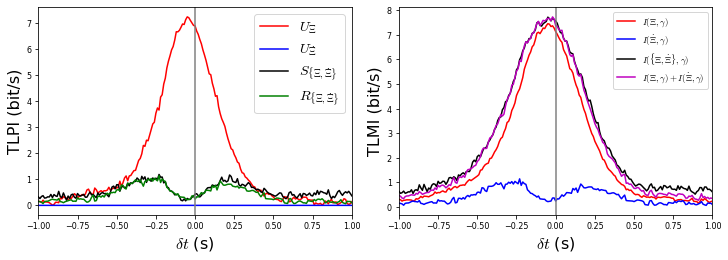

In [ ]:
plt.rcParams["font.size"] = 8
i = 1
Information_list = STKInformation_list.copy()

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)

ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
# ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.legend( (r'$I(\Xi,\gamma)$', r'$I(\dot\Xi,\gamma)$', r'$I(\{\Xi,\dot\Xi\},\gamma)$', r'$I(\Xi,\gamma)+I(\dot\Xi,\gamma)$'),
           loc='best', prop={'size': 9})


# fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
fig.set_size_inches(10, 3.5)

In [ ]:
SVDSTKrstate_list = [ SG(r, dt, 0, 10, 10) for r in SVDr1_list]

window = [-1,1] # second
SVDSTKInformation_list = [0]*len(LPOU_list)
for i in range(len(LPOU_list)):
    timeshift, SVDSTKInformation_list[i] = PIfunc(SVDSTKrstate_list[i], xstate_list[i], tvstate_list[i], dt, window)

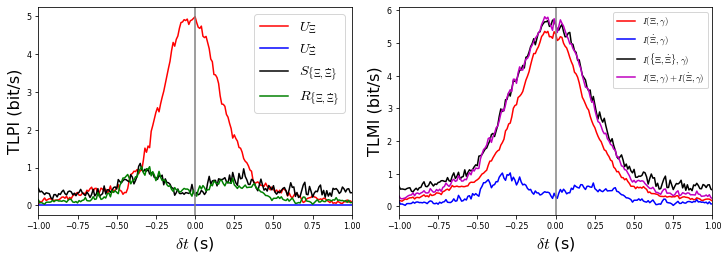

In [ ]:
plt.rcParams["font.size"] = 8
i = 1
Information_list = SVDSTKInformation_list.copy()

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax2.set_ylabel('TLPI (bit/s)', fontsize = 16)
ax2.legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 14})
ax2.axvline(0, c = 'gray')
ax2.set_xlim(window)

ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax3.plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
# ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax3.set_ylabel('TLMI (bit/s)', fontsize = 16)
ax3.axvline(0, c = 'gray')
ax3.set_xlim(window)
ax3.legend( (r'$I(\Xi,\gamma)$', r'$I(\dot\Xi,\gamma)$', r'$I(\{\Xi,\dot\Xi\},\gamma)$', r'$I(\Xi,\gamma)+I(\dot\Xi,\gamma)$'),
           loc='best', prop={'size': 9})


# fig.tight_layout(pad = 0, w_pad = 0.0, h_pad=0.0)
fig.set_size_inches(10, 3.5)

## Final Fig

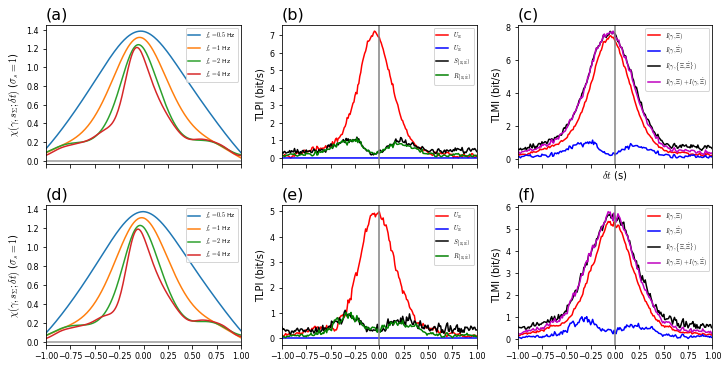

In [ ]:
plt.rcParams["font.size"] = 10
plt.rcParams['xtick.labelsize'] =  8
plt.rcParams['ytick.labelsize'] =  8

fig, ax = plt.subplots(2,3, constrained_layout=True, sharex =True)
fig.set_size_inches(10,5)
for i in range(len(Inten_list)):
    ax[0][0].plot(timeaxis,STKXcorr[i])
ax[0][0].set_xlim(window)
ax[0][0].set_ylabel(r'$\chi(\gamma, s_\Sigma; \delta t)$ ($\sigma_s=1$)')
# ax[0][0].set_xlabel(r'$\delta t$ (s)')
ax[0][0].set_title('(a)', loc = 'left', fontsize = 16)
ax[0][0].axhline(0, c = 'gray', alpha = 0.8)
ax[0][0].legend( (r'$f_c=0.5$ Hz', r'$f_c=1$ Hz', r'$f_c=2$ Hz', r'$f_c=4$ Hz'),  fontsize = 6 )

Information_list = STKInformation_list.copy()
i = 1
ax[0][1].set_title('(b)', loc = 'left', fontsize = 16)
ax[0][1].plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax[0][1].plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax[0][1].plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax[0][1].plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax[0][1].set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax[0][1].set_ylabel('TLPI (bit/s)')
ax[0][1].legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 6})
ax[0][1].axvline(0, c = 'gray')
ax[0][1].set_xlim(window)

ax[0][2].set_title('(c)', loc = 'left', fontsize = 16)
ax[0][2].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax[0][2].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax[0][2].plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax[0][2].plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
# ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax[0][2].set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax[0][2].set_ylabel('TLMI (bit/s)')
ax[0][2].axvline(0, c = 'gray')
ax[0][2].set_xlim(window)
ax[0][2].legend( (r'$I(\gamma,\Xi)$', r'$I(\gamma,\dot\Xi)$', r'$I(\gamma,\{\Xi,\dot\Xi\})$', r'$I(\gamma,\Xi)+I(\gamma,\dot\Xi)$'),
           loc='best', prop={'size': 6})


for i in range(len(Inten_list)):
    ax[1][0].plot(timeaxis,SVDSTKXcorr[i])
ax[1][0].set_xlim(window)
ax[1][0].set_ylabel(r'$\chi(\gamma, s_\Sigma; \delta t)$ ($\sigma_s=1$)')
# ax[1][0].set_xlabel(r'$\delta t$ (s)')
ax[1][0].set_title('(d)', loc = 'left', fontsize = 16)
ax[1][0].axhline(0, c = 'gray', alpha = 0.8)
ax[1][0].legend( (r'$f_c=0.5$ Hz', r'$f_c=1$ Hz', r'$f_c=2$ Hz', r'$f_c=4$ Hz'),  fontsize = 6 )

Information_list = SVDSTKInformation_list.copy()
i = 1
ax[1][1].set_title('(e)', loc = 'left', fontsize = 16)
ax[1][1].plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax[1][1].plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax[1][1].plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax[1][1].plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax[0][1].set_xlabel(r'$\delta t$ (s)', fontsize = 16)
ax[1][1].set_ylabel('TLPI (bit/s)')
ax[1][1].legend( (r'$U_\Xi$', r'$U_\dot\Xi$', r'$S_{\{\Xi,\dot\Xi\}}$', r'$R_{\{\Xi,\dot\Xi\}}$'), loc='best', prop={'size': 6})
ax[1][1].axvline(0, c = 'gray')
ax[1][1].set_xlim(window)

ax[1][2].set_title('(f)', loc = 'left', fontsize = 16)
ax[1][2].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax[1][2].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax[1][2].plot(timeshift, Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
                   +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax[1][2].plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
# ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0][2].set_xlabel(r'$\delta t$ (s)')
ax[1][2].set_ylabel('TLMI (bit/s)')
ax[1][2].axvline(0, c = 'gray')
ax[1][2].set_xlim(window)
ax[1][2].legend( (r'$I(\gamma,\Xi)$', r'$I(\gamma,\dot\Xi)$', r'$I(\gamma,\{\Xi,\dot\Xi\})$', r'$I(\gamma,\Xi)+I(\gamma,\dot\Xi)$'),
           loc='best', prop={'size': 6})